# 2D (x-y) field generation: resolution sensitivity

In [1]:
import os
#from tqdm import tqdm
#from itertools import product

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats
import xrft

#from gptide import cov
#from gptide import GPtideScipy
#from gptide import stats as gpstats

import nwatools.stats as st

#data_dir = "data/"
#data_dir = "/home1/scratch/aponte/"
#data_dir = "/home/datawork-lops-osi/aponte/nwa/drifter_stats"
#store = True

/home1/datawork/aponte/miniconda3/envs/equinox/lib/python3.10/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/home1/datawork/aponte/miniconda3/envs/equinox/lib/python3.10/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(


/home1/datawork/aponte/code/pynsitu/pynsitu/__init__.py:46: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  hour = Timedelta("1H")
ERROR 1: PROJ: proj_create_from_database: Open of /home1/datawork/aponte/miniconda3/envs/equinox/share/proj failed


In [2]:
from dask.distributed import Client
client = Client()
client

/home1/datawork/aponte/miniconda3/envs/equinox/lib/python3.10/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/home1/datawork/aponte/miniconda3/envs/equinox/lib/python3.10/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/home1/datawork/aponte/miniconda3/envs/equinox/lib/python3.10/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/home1/datawork/aponte/miniconda3/envs/equinox/lib/python3.10/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.transitio

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 56,Total memory: 100.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:53388,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 56
Started: Just now,Total memory: 100.00 GiB
Comm: tcp://127.0.0.1:33544,Total threads: 7
Dashboard: http://127.0.0.1:48835/status,Memory: 12.50 GiB
Nanny: tcp://127.0.0.1:55059,


## Generate velocity fields

The different flow formulations considered are:

1. direct velocity field generation: $u$ and $v$ specified independantly and with separable autocorrelations (x/y/t).
2. streamfunction and potential field generation: $u=-\partial_y \psi + \partial_x \phi$ and $v=\partial_x \psi + \partial_y \phi$, where $\psi$ and $\phi$ are independent fields with separable autocorrelations.

**Points addressed:**

- kinetic energy spectral slopes need to match general expectation of isotropic wavenumber spectral slope between -3 and -2.
- separability implies non-isotropic spatial spectra and weird deformation (e.g. vorticity, divergence) fields, we opt for isotropic formulation

**Points to potentially in the future address:**

- $\psi$ $\phi$ correlations have been considered in the past, see mention of spirality in [Wang and Buhler 2021]
- could we make the problem 2D periodic?

**Note:** Link Matern parameters ($\nu$, n=1) to spectral slope $s$ ($k^{-s}$): $s=2\nu+n$.

In [3]:
#### 
# Input parameters

# signal characteristics
U = .1     # amplitude m/s (will be rescale for streamfunction/potential amplitudes) - reference case
λx = 100   # km
λy = 100   # km

# velocity field formulation
#kind = "uv"
kind, pp_ratio = "pp", 0.

# covariance mode
#Cmodel=("matern2_iso", "matern12")
Cmodel = "matern32_iso"

In [4]:
### velocity field formulation

if kind=="uv":
    # u-v formulation
    η = U
    amplitudes = (η, η)
    suffix = kind
elif kind=="pp":
    # psi-phi field formulation
    #λ = np.sqrt(λx**2 + λy**2)
    λ = λx
    if "matern32" in Cmodel:
        ν = 3/2
    else:
        assert False, "implement scaling factor"
    η = np.sqrt((ν-1)/ν)*U*λ
    amplitudes = (η*(1-pp_ratio), η*pp_ratio)
    #scale = λ*0.5
    #amplitudes = (scale * amplitudes[0], scale * amplitudes[1])

### start assembling covariances

In [5]:
# Base grid parameters: size, spacing
Nx, dx = 1000, 1.  # km
Ny, dy = 1000, 1.  # km

In [6]:
def generate_flow(factor, Nx, Ny, dx, dy, chunks=None, seed=0):

    # rescale grid parameters 
    Nx = Nx//factor
    Ny = Ny//factor
    dx = dx*factor  # km
    dy = dy*factor  # km

    # actually generate covariances
    C, X, N, isotropy = st.generate_spatial_covariances(Cmodel, Nx, Ny, dx, dy, λx, λy, chunks=chunks)

    # generate flow
    ds = st.generate_uv(kind, N, C, X, amplitudes, seed=seed)

    return ds.compute()

In [7]:
ds10 = generate_flow(10, Nx, Ny, dx, dy)

Space covariance model: matern32_iso
 time = False,  isotropy = True  


In [8]:
#ds5 = generate_flow(5, Nx, Ny, dx, dy) # not going through
ds5 = generate_flow(5, Nx, Ny, dx, dy, chunks=(10,-1))

Space covariance model: matern32_iso
 time = False,  isotropy = True  


/home1/datawork/aponte/miniconda3/envs/equinox/lib/python3.10/site-packages/dask/array/core.py:4836: PerformanceWarning: Increasing number of chunks by factor of 20
  result = blockwise(
/home1/datawork/aponte/miniconda3/envs/equinox/lib/python3.10/site-packages/dask/array/core.py:4836: PerformanceWarning: Increasing number of chunks by factor of 20
  result = blockwise(


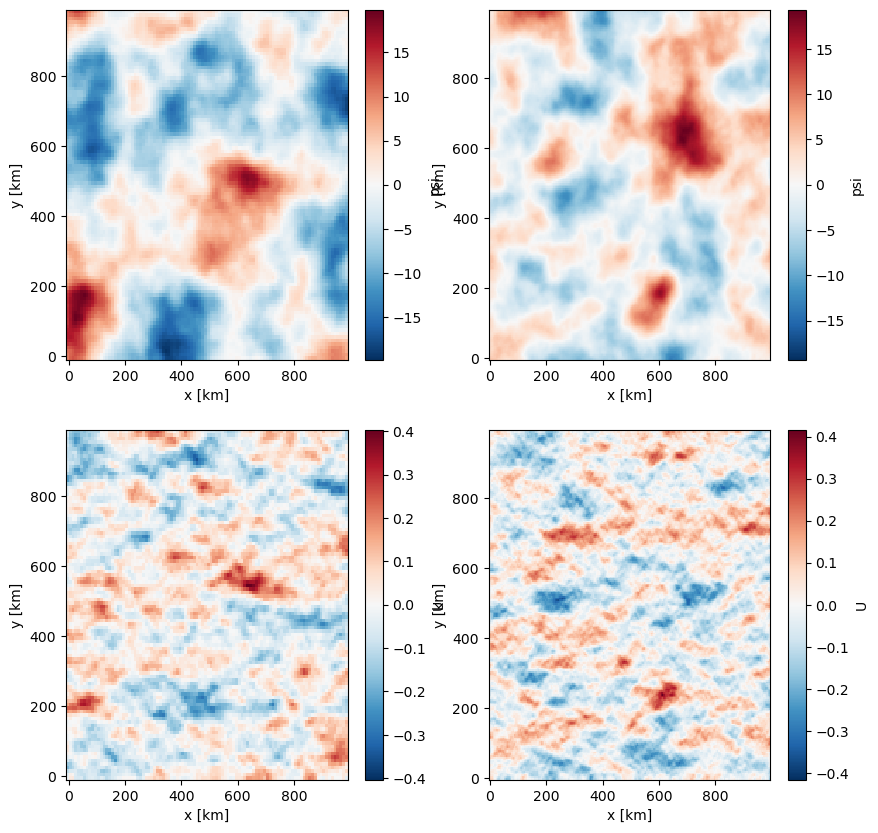

In [9]:
fig, axes = plt.subplots(2,2,figsize=(10,10))
ds10["psi"].plot(ax=axes[0,0])
ds5["psi"].plot(ax=axes[0,1])
ds10["U"].plot(ax=axes[1,0])
ds5["U"].plot(ax=axes[1,1])

In [10]:
std10 = ds10.std()
std5 = ds5.std()

In [11]:
def print_std(std):
    # verifies amplitudes on full dataset: psi, phi, u, v
    x, y = η*(1-pp_ratio), float(std.psi)
    print(f"psi, input={x:.2f}, measured={y:.2f}, diff={(y-x)/x*100:.1f}%")
    #
    #x, y = η*pp_ratio, float(std.phi)
    #print(f"phi, input={x:.2f}, measured={y:.2f}, diff={(y-x)/x*100:.1f}%")
    #
    x, y = U, float(std.U)
    print(f"U, input={x:.3f}, measured={y:.3f}, diff={(y-x)/x*100:.1f}%")
    #
    x, y = U, float(std.V)
    print(f"V, input={x:.3f}, measured={y:.3f}, diff={(y-x)/x*100:.1f}%")

In [12]:
print_std(std10)

psi, input=5.77, measured=6.75, diff=16.9%
U, input=0.100, measured=0.094, diff=-5.6%
V, input=0.100, measured=0.089, diff=-11.4%


In [13]:
print_std(std5)

psi, input=5.77, measured=5.08, diff=-12.0%
U, input=0.100, measured=0.097, diff=-2.6%
V, input=0.100, measured=0.090, diff=-9.9%


In [ ]:
D40 = []
D20 = []
D10 = []
D5 = []
seeds = list(range(20))
for seed in seeds:
    print(f"---- {seed}/{len(seeds)}")
    ds = generate_flow(40, Nx, Ny, dx, dy, seed=seed)
    D40.append(ds.std())
    ds = generate_flow(20, Nx, Ny, dx, dy, seed=seed)
    D20.append(ds.std())
    ds = generate_flow(10, Nx, Ny, dx, dy, seed=seed)
    D10.append(ds.std())
    ds = generate_flow(5, Nx, Ny, dx, dy, seed=seed, chunks=(10,-1))
    D5.append(ds.std())

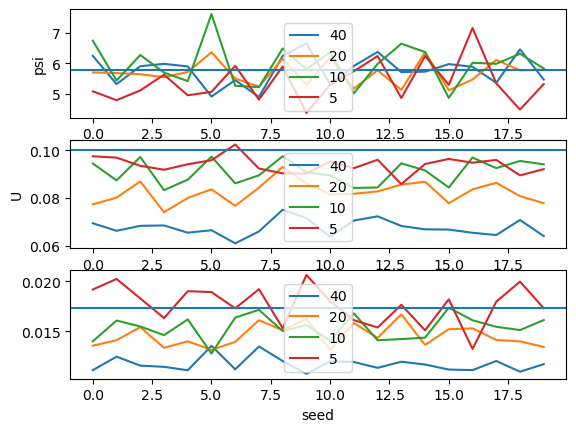

In [38]:
std40 = xr.concat(D40, dim=pd.Index(seeds, name='seed'))
std20 = xr.concat(D20, dim=pd.Index(seeds, name='seed'))
std10 = xr.concat(D10, dim=pd.Index(seeds, name='seed'))
std5 = xr.concat(D5, dim=pd.Index(seeds, name='seed'))


fig, axes = plt.subplots(3,1)

ax, v, ref = axes[0], "psi", η*(1-pp_ratio)
std40[v].plot(ax=ax, label="40")
std20[v].plot(ax=ax, label="20")
std10[v].plot(ax=ax, label="10")
std5[v].plot(ax=ax, label="5")
ax.legend()
ax.axhline(ref)

ax, v, ref = axes[1], "U", U
std40[v].plot(ax=ax, label="40")
std20[v].plot(ax=ax, label="20")
std10[v].plot(ax=ax, label="10")
std5[v].plot(ax=ax, label="5")
ax.legend()
ax.axhline(ref)

ax, ref = axes[2], U / η*(1-pp_ratio)
(std40["U"]/std40["psi"]).plot(ax=ax, label="40")
(std20["U"]/std20["psi"]).plot(ax=ax, label="20")
(std10["U"]/std10["psi"]).plot(ax=ax, label="10")
(std5["U"]/std5["psi"]).plot(ax=ax, label="5")
ax.legend()
ax.axhline(ref)

Text(0, 0.5, 'rms(U)/rms(psi)')

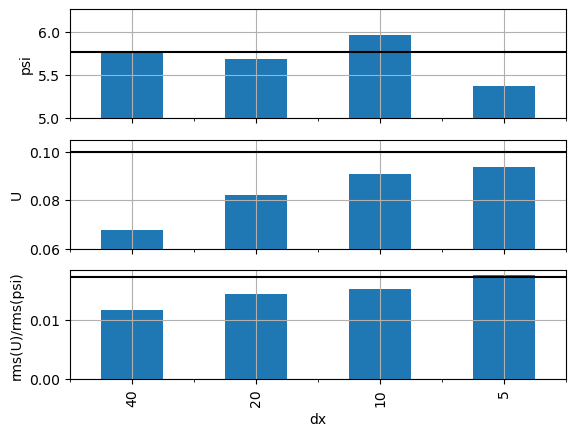

In [40]:
std = xr.concat([std40, std20, std10, std5], dim=pd.Index([40,20,10,5], name="dx"))

fig, axes = plt.subplots(3,1, sharex=True)

ax, v, ref = axes[0], "psi", η*(1-pp_ratio)
std[v].mean("seed").to_series().plot.bar(ax=ax)
ax.axhline(ref, color="k")
ax.set_ylim(5, None)
ax.grid()
ax.set_ylabel(v)

ax, v, ref = axes[1], "U", U
std[v].mean("seed").to_series().plot.bar(ax=ax)
ax.axhline(ref, color="k")
ax.set_ylim(0.06, None)
ax.grid()
ax.set_ylabel(v)

ax, ref = axes[2], U / η*(1-pp_ratio)
(std["U"]/std["psi"]).mean("seed").to_series().plot.bar(ax=ax)
ax.axhline(ref, color="k")
#ax.set_ylim(0.06, None)
ax.grid()
ax.set_ylabel("rms(U)/rms(psi)")

Predicting the drop of variance with a second order derivative:

$
\begin{align}
D^2(dx) &= \langle \frac{[f(x+dx)-f(x-dx)]^2}{4dx^2} \rangle , \\
&= \frac{ \langle f^2 \rangle 
- \langle f(x+dx)f(x-dx) \rangle}{2dx^2} \\
&= \langle f^2 \rangle \frac{ 1
- K(2dx) }{2dx^2}, \\
&= D^2(0) S^2(dx), \\
D^2(0) &= - \langle f^2 \rangle K''(0)
 = \langle f^2 \rangle \frac{\nu}{(\nu-1)\lambda^2}, \\
S^2(dx) &= \frac{(\nu-1)\lambda^2}{\nu} \times \frac{ 1
- K(2dx) }{2dx^2}
\end{align}
$ 

where $K(0)=1$ is the Matern covariance.


Text(0.5, 1.0, 'drop in rms')

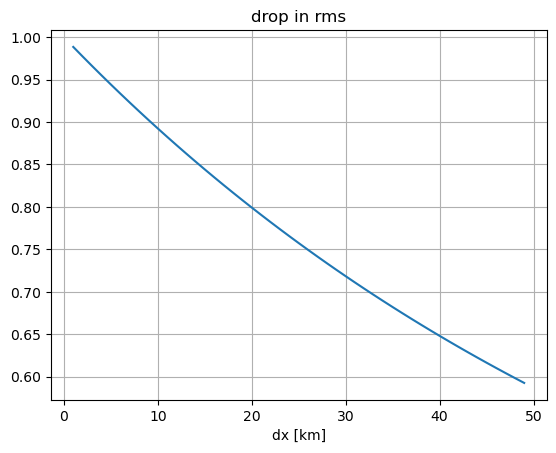

In [76]:
dx = np.arange(1,50)
#dx = np.arange(.1,10)


S2 =  lambda dx, λ, ν: λx**2*(ν-1)/ν * (1 - st.matern_general(2*dx, 1., ν, λx))/2/dx**2
#D20 = st.matern_general_d2(dx*0, 1., ν, λx)

fig, ax = plt.subplots(1,1)
ax.plot(dx, np.sqrt(S2(dx, λx, ν)))
#ax.plot(dx, H/H[0])
ax.grid()
ax.set_xlabel("dx [km]")
ax.set_title("drop in rms")




In [72]:
np.sqrt(S2(std.dx, λx, ν))

<xarray.DataArray 'dx' (dx: 4)>
array([0.64807393, 0.79925261, 0.89245577, 0.94429639])
Coordinates:
  * dx       (dx) int64 40 20 10 5

Text(0, 0.5, 'rms(U)/rms(psi)')

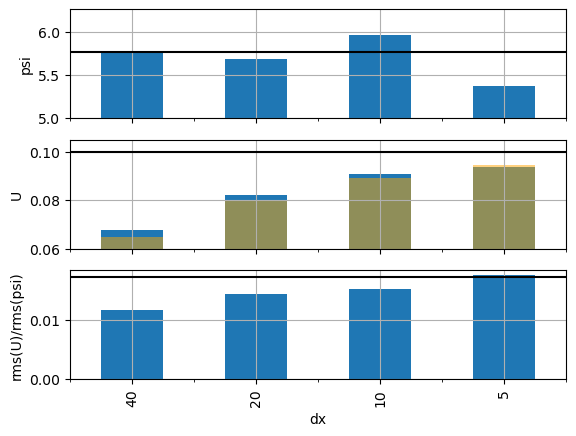

In [75]:
fig, axes = plt.subplots(3,1, sharex=True)

ax, v, ref = axes[0], "psi", η*(1-pp_ratio)
std[v].mean("seed").to_series().plot.bar(ax=ax)
ax.axhline(ref, color="k")
ax.set_ylim(5, None)
ax.grid()
ax.set_ylabel(v)

ax, v, ref = axes[1], "U", U
std[v].mean("seed").to_series().plot.bar(ax=ax)
#ax.scatter(std.dx, , s=200, color="orange")
(ref*np.sqrt(S2(std.dx, λx, ν))).to_series().plot.bar(ax=ax, color="orange", alpha=0.5)
ax.axhline(ref, color="k")
ax.set_ylim(0.06, None)
ax.grid()
ax.set_ylabel(v)

ax, ref = axes[2], U / η*(1-pp_ratio)
(std["U"]/std["psi"]).mean("seed").to_series().plot.bar(ax=ax)
ax.axhline(ref, color="k")
#ax.set_ylim(0.06, None)
ax.grid()
ax.set_ylabel("rms(U)/rms(psi)")